In [12]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
# !wget https://github.com/text-machine-lab/MUTT/raw/master/data/flickr/Flickr8k.token.txt
# !wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/76.0.3809.100 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3" --header="Accept-Language: en-US,en;q=0.9,ta;q=0.8" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-datasets/159035/364443/flicker8k-dataset.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1566381201&Signature=STE%2F89nlvexuXQ3aETdTtj7CgTfBscjNH3nd1TvysNG0Xsse7BtfF00cs9M3J%2FyAY8dF0lCw%2FD6X7e51bgR2%2BUMOG%2BOO1cNe5TBRoI5scWpmNX%2BrhZsaur3XnvjxKhplZHgJ6%2Ft7K%2B5nXNEeFch6eyO9jQJiVjUNQsEWbZhZb%2F0tdqNwyvShWZGEcACqKA5Bm5erBThMVW36zlB5nEHTnpKH1%2FyLh0mQ1GFViwgZQYG6vfyl9ywFtT738hvZ2mnx9NZBuY7cyoxyZd7S%2FUTWGOWims%2FeH598o2%2BIGvsDYzeMcVupou5I2YqNBzf18a4cgEMNXUm4r0tm3IqUt8QK5Q%3D%3D" -O "CurlWget1880" -c
# !mv CurlWget1880 'dataset.zip'
# from zipfile import ZipFile
# zipfile = ZipFile('dataset.zip')
# zipfile.extractall()

In [3]:
# import glob
# names = glob.glob("Flic*.zip")
# for name in names:
#   zipfile = ZipFile(name)
#   zipfile.extractall()

In [4]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# ZipFile('glove.6B.zip').extractall()

--2019-08-18 20:28:59--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-08-18 20:28:59--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-08-18 20:29:00--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [13]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = "Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [14]:
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [15]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [16]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [17]:
descriptions['1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [18]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [19]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [20]:
descriptions['1001773457_577c3a7d70']

['black dog and spotted dog are fighting',
 'black dog and tricolored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

In [21]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [22]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [23]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = 'Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [24]:
# Below path contains all the images
images = 'Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

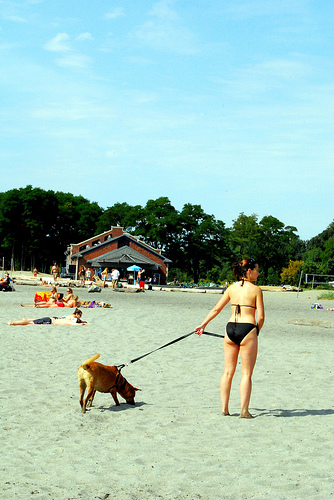

In [25]:
img[0]
from PIL import Image
Image.open(img[0])

In [26]:
# Below file conatains the names of images to be used in train data
train_images_file = 'Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [27]:
# Below file conatains the names of images to be used in test data
test_images_file = 'Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [28]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [29]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [30]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

W0818 20:32:06.236442 140587603834688 deprecation_wrapper.py:119] From /home/bala/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0818 20:32:06.244467 140587603834688 deprecation_wrapper.py:119] From /home/bala/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0818 20:32:06.285522 140587603834688 deprecation_wrapper.py:119] From /home/bala/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0818 20:32:06.295852 140587603834688 deprecation_wrapper.py:119] From /home/bala/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session in

96116736/96112376 [==============================] - 30s 0us/step


In [31]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [32]:
model_new.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [33]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [34]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 121.54075360298157


In [35]:
import pickle

## Save Encoded Image Features as Pickle

In [36]:
# Save the bottleneck train features to disk
with open("encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [37]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 19.158788204193115


In [38]:
# Save the bottleneck test features to disk
with open("encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [39]:
train_features = load(open("encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [40]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [41]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [42]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [43]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [44]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [45]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [0]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip

In [0]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# ZipFile('glove.6B.zip').extractall()

In [46]:
# Load Glove vectors
glove_dir = './'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [47]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [48]:
embedding_matrix.shape

(1652, 200)

In [49]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])

decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)

W0818 20:35:22.068624 140587603834688 deprecation.py:506] From /home/bala/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0818 20:35:22.274915 140587603834688 deprecation.py:323] From /home/bala/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2974: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [50]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [51]:
model.layers[2]

In [52]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [53]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

W0818 20:35:24.090602 140587603834688 deprecation_wrapper.py:119] From /home/bala/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [56]:
epochs = 5
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [57]:
# !mkdir './model_weights'

In [58]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 64s 32ms/step - loss: 4.1295 - acc: 0.2413
Epoch 1/1
2000/2000 [==============================] - 61s 31ms/step - loss: 3.4272 - acc: 0.2940
Epoch 1/1
2000/2000 [==============================] - 61s 31ms/step - loss: 3.2041 - acc: 0.3132
Epoch 1/1
2000/2000 [==============================] - 61s 31ms/step - loss: 3.0700 - acc: 0.3255
Epoch 1/1
2000/2000 [==============================] - 61s 31ms/step - loss: 2.9737 - acc: 0.3337


In [0]:
# Slow down a bit...

In [59]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [60]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

Epoch 1/1
1000/1000 [==============================] - 32s 32ms/step - loss: 2.8652 - acc: 0.3460
Epoch 1/1
1000/1000 [==============================] - 32s 32ms/step - loss: 2.8161 - acc: 0.3517
Epoch 1/1
1000/1000 [==============================] - 32s 32ms/step - loss: 2.7803 - acc: 0.3545
Epoch 1/1
1000/1000 [==============================] - 32s 32ms/step - loss: 2.7422 - acc: 0.3572
Epoch 1/1
1000/1000 [==============================] - 32s 32ms/step - loss: 2.7056 - acc: 0.3615
Epoch 1/1
1000/1000 [==============================] - 32s 32ms/step - loss: 2.6742 - acc: 0.3649
Epoch 1/1
1000/1000 [==============================] - 32s 32ms/step - loss: 2.6457 - acc: 0.3680
Epoch 1/1
1000/1000 [==============================] - 32s 32ms/step - loss: 2.6202 - acc: 0.3706
Epoch 1/1
1000/1000 [==============================] - 32s 32ms/step - loss: 2.5978 - acc: 0.3735
Epoch 1/1
1000/1000 [==============================] - 32s 32ms/step - loss: 2.5771 - acc: 0.3752


In [61]:
model.save_weights('./model_weights/model_30.h5')

In [72]:
# model.optimizer.lr, model.optimizer.lr*10

(0.0001, 0.001)

In [62]:
model.load_weights('./model_weights/model_30.h5')

In [76]:
images = 'Flicker8k_Dataset/'

In [77]:
with open("encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [78]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

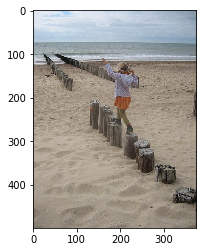

Greedy: two men sit on rocks by the water


In [84]:
z=37
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

## Experimentation

In [73]:
epochs=25
model.optimizer.lr = 0.001
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

Epoch 1/1
1000/1000 [==============================] - 32s 32ms/step - loss: 2.5588 - acc: 0.3783
Epoch 1/1
1000/1000 [==============================] - 32s 32ms/step - loss: 2.5378 - acc: 0.3817
Epoch 1/1
1000/1000 [==============================] - 32s 32ms/step - loss: 2.5219 - acc: 0.3826
Epoch 1/1
1000/1000 [==============================] - 32s 32ms/step - loss: 2.5072 - acc: 0.3840
Epoch 1/1
1000/1000 [==============================] - 32s 32ms/step - loss: 2.4907 - acc: 0.3868
Epoch 1/1
1000/1000 [==============================] - 32s 32ms/step - loss: 2.4747 - acc: 0.3886
Epoch 1/1
1000/1000 [==============================] - 32s 32ms/step - loss: 2.4648 - acc: 0.3896
Epoch 1/1
1000/1000 [==============================] - 32s 32ms/step - loss: 2.4534 - acc: 0.3910
Epoch 1/1
1000/1000 [==============================] - 32s 32ms/step - loss: 2.4416 - acc: 0.3935
Epoch 1/1
1000/1000 [==============================] - 32s 32ms/step - loss: 2.4286 - acc: 0.3940
Epoch 1/1
1000/1000 

In [74]:
model.save_weights('./model_weights/model_acc409.h5')

In [75]:
epochs=25
model.optimizer.lr = 0.01
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

Epoch 1/1
1000/1000 [==============================] - 32s 32ms/step - loss: 2.3170 - acc: 0.4100
Epoch 1/1
1000/1000 [==============================] - 32s 32ms/step - loss: 2.3124 - acc: 0.4109
Epoch 1/1
1000/1000 [==============================] - 32s 32ms/step - loss: 2.3057 - acc: 0.4127
Epoch 1/1
1000/1000 [==============================] - 32s 32ms/step - loss: 2.3035 - acc: 0.4115
Epoch 1/1
1000/1000 [==============================] - 32s 32ms/step - loss: 2.2970 - acc: 0.4134
Epoch 1/1
1000/1000 [==============================] - 32s 32ms/step - loss: 2.2922 - acc: 0.4146
Epoch 1/1
1000/1000 [==============================] - 32s 32ms/step - loss: 2.2889 - acc: 0.4139
Epoch 1/1
1000/1000 [==============================] - 32s 32ms/step - loss: 2.2845 - acc: 0.4144
Epoch 1/1
1000/1000 [==============================] - 32s 32ms/step - loss: 2.2813 - acc: 0.4164
Epoch 1/1
1000/1000 [==============================] - 32s 32ms/step - loss: 2.2787 - acc: 0.4156
Epoch 1/1
1000/1000 

In [85]:
epochs=10
model.optimizer.lr = 0.01
for i in range(1):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/10
1000/1000 [==============================] - 32s 32ms/step - loss: 2.2295 - acc: 0.4248
Epoch 2/10
1000/1000 [==============================] - 32s 32ms/step - loss: 2.2287 - acc: 0.4237
Epoch 3/10
1000/1000 [==============================] - 32s 32ms/step - loss: 2.2225 - acc: 0.4249
Epoch 4/10
1000/1000 [==============================] - 32s 32ms/step - loss: 2.2212 - acc: 0.4244
Epoch 5/10
1000/1000 [==============================] - 32s 32ms/step - loss: 2.2166 - acc: 0.4249
Epoch 6/10
1000/1000 [==============================] - 32s 32ms/step - loss: 2.2161 - acc: 0.4251
Epoch 7/10
1000/1000 [==============================] - 32s 32ms/step - loss: 2.2133 - acc: 0.4259
Epoch 8/10
1000/1000 [==============================] - 32s 32ms/step - loss: 2.2103 - acc: 0.4258
Epoch 9/10
1000/1000 [==============================] - 32s 32ms/step - loss: 2.2100 - acc: 0.4265
Epoch 10/10
1000/1000 [==============================] - 32s 32ms/step - loss: 2.2060 - acc: 0.4278


In [86]:
epochs=50
model.optimizer.lr = 0.001
for i in range(1):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/50
1000/1000 [==============================] - 32s 32ms/step - loss: 2.2051 - acc: 0.4265
Epoch 2/50
1000/1000 [==============================] - 32s 32ms/step - loss: 2.2020 - acc: 0.4275
Epoch 3/50
1000/1000 [==============================] - 32s 32ms/step - loss: 2.2027 - acc: 0.4275
Epoch 4/50
1000/1000 [==============================] - 32s 32ms/step - loss: 2.2007 - acc: 0.4277
Epoch 5/50
1000/1000 [==============================] - 32s 32ms/step - loss: 2.1953 - acc: 0.4280
Epoch 6/50
1000/1000 [==============================] - 32s 32ms/step - loss: 2.1907 - acc: 0.4301
Epoch 7/50
1000/1000 [==============================] - 32s 32ms/step - loss: 2.1937 - acc: 0.4281
Epoch 8/50
1000/1000 [==============================] - 32s 32ms/step - loss: 2.1919 - acc: 0.4289
Epoch 9/50
1000/1000 [==============================] - 32s 32ms/step - loss: 2.1892 - acc: 0.4294
Epoch 10/50
1000/1000 [==============================] - 32s 32ms/step - loss: 2.1899 - acc: 0.4296
Epoch 11/

In [87]:
model.save_weights('./model_weights/model_4388.h5')

In [88]:
epochs=5
model.optimizer.lr = 0.1
for i in range(1):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/5
1000/1000 [==============================] - 32s 32ms/step - loss: 2.1340 - acc: 0.4391
Epoch 2/5
1000/1000 [==============================] - 32s 32ms/step - loss: 2.1337 - acc: 0.4400
Epoch 3/5
1000/1000 [==============================] - 32s 32ms/step - loss: 2.1316 - acc: 0.4392
Epoch 4/5
1000/1000 [==============================] - 32s 32ms/step - loss: 2.1313 - acc: 0.4393
Epoch 5/5
1000/1000 [==============================] - 32s 32ms/step - loss: 2.1317 - acc: 0.4393


In [89]:
epochs=5
model.optimizer.lr = 0.5
for i in range(1):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/5
1000/1000 [==============================] - 32s 32ms/step - loss: 2.1291 - acc: 0.4386
Epoch 2/5
1000/1000 [==============================] - 32s 32ms/step - loss: 2.1297 - acc: 0.4396
Epoch 3/5
1000/1000 [==============================] - 32s 32ms/step - loss: 2.1272 - acc: 0.4406
Epoch 4/5
1000/1000 [==============================] - 32s 32ms/step - loss: 2.1271 - acc: 0.4402
Epoch 5/5
1000/1000 [==============================] - 32s 32ms/step - loss: 2.1278 - acc: 0.4413


In [90]:
model.save_weights('./model_weights/model_04413.h5')